In [1]:
from project_heart.lv import LV
import numpy as np
import pyvista as pv
pv.set_jupyter_backend("pythreejs")

import os
from pathlib import Path

from project_heart.enums import *

from matplotlib import pyplot as plt

In [2]:
import pandas as pd
import numpy as np

# Load LV and extract metrics

## Load file

In [3]:
from project_heart.examples import get_lv_typeA
lv = get_lv_typeA(filepath="C:/Users/igorp/Downloads/0.28_70.00_40.00_LVMYO_HEX8_83648_wr.xplt", statesfile=None,
                  id_region_kwargs={
                        "border_thresh_base":1.5, 
                        "border_thresh_endo":1.5, 
                        "border_thresh_epi":1.5,
                  })

INFO:LV_RegionIdentifier.identify_regions_typeA:Identifying regions from 'type A' geometry.
INFO:LV_RegionIdentifier.identify_endo_epi_base_borders_from_nodesets:len(endo_base): 329
INFO:LV_RegionIdentifier.identify_endo_epi_base_borders_from_nodesets:len(epi_base): 369


In [4]:
lv.plot("surface", 
        scalars=LV_MESH_DATA.SURFS_DETAILED,
        categorical=True,
        )

Renderer(camera=PerspectiveCamera(aspect=1.5, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, 1…

## Create speckles that match manual extracted nodes

In [5]:
# names = ["subapex", "apex", "superapex", "submid", "mid", "supermid", "subbase", "base", "superbase"]
k = 0.89
d = 1.5
spks1 = lv.create_speckles(
            collection="MANUAL_CALC_CIRC_6",
            group="endo",
            name="superbase",
            from_nodeset=LV_SURFS.ENDO,
            d=d,
            k=k,
            normal_to=[0.0, 0.0, 1.0],
            n_subsets=6,
            subsets_criteria="angles",
            cluster_criteria="angles3",
            n_clusters=16,
            t=0.0,
        )
spks2 = lv.create_speckles(
            collection="MANUAL_CALC_CIRC_6",
            group="epi",
            name="superbase",
            from_nodeset=LV_SURFS.EPI,
            d=d,
            k=k,
            normal_to=[0.0, 0.0, 1.0],
            n_subsets=6,
            subsets_criteria="angles",
            cluster_criteria="angles3",
            n_clusters=16,
            t=0.0,
        )

spks3 = lv.create_speckles(
            collection="MANUAL_CALC_CIRC_1",
            group="endo",
            name="superbase",
            from_nodeset=LV_SURFS.ENDO,
            d=d,
            k=k,
            normal_to=[0.0, 0.0, 1.0],
            n_subsets=0,
            subsets_criteria="angles",
            cluster_criteria="angles3",
            n_clusters=50,
            t=0.0,
        )

In [6]:
spks4 = lv.create_speckles(
            collection="MANUAL_CALC_LONG_1",
            group="endo",
            name="0.0",
            from_nodeset=LV_SURFS.ENDO,
            exclude_nodeset=LV_SURFS.BASE, # does not afect ideal case
            d=1.3,
            k=0.5,
            normal_to=[1.0, 0.0, 0.0],
            n_subsets=0,
            subsets_criteria="z2",
            n_clusters=75,
            cluster_criteria="angles3",
            clusters_vector_ref=np.asarray([0,0,1]),
            t=0.0,
        )

In [7]:
lv.plot_speckles(spks4, show_clusters=True, show_clusters_centers=True)

Renderer(camera=PerspectiveCamera(aspect=1.5, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, 1…

## Extract metrics

In [9]:
df = lv.extract_geometrics({
        "volume":{},
        "apex_base_over_timesteps": {
            "apex_spks": {"spk_name":"apex", "spk_group":"endo", "spk_collection":"LA"},
            "base_spks": {"spk_name":"base", "spk_group":"endo", "spk_collection":"LA"},
            },
        "longitudinal_distance": {
            "apex_spks": {"spk_name":"apex", "spk_collection":"LA"},
            "base_spks": {"spk_name":"base", "spk_collection":"LA"},
            "approach":"centroid", 
            "use_axis_aligment":False,
            "reduce_by":{"group"}
            },
        "radial_distance": {
            "spks": {"spk_collection":"MANUAL_CALC_CIRC_6"},
            "approach":"moving_vector",
            "reduce_by":{"group", "name", "group_name"},
            },
        "radial_length": {
            "spks": {"spk_collection":"MANUAL_CALC_CIRC_6"},
            "approach":"moving_centers",
            "reduce_by":{"group", "name", "group_name"},
            },
        "wall_thickness": {
            "endo_spks": {"spk_group":"endo", "spk_collection":"MANUAL_CALC_CIRC_6"},
            "epi_spks": {"spk_group":"epi", "spk_collection":"MANUAL_CALC_CIRC_6"},
            "approach":"radial_distance",
            "reduce_by":{"name"},
            },
        "longitudinal_length": {
            "spks": {"spk_collection":"long-6"},
            "approach":"k_ids",
            "reduce_by":{"subset"},
            "merge_subset":{
                    5: 0, 
                    4: 1, 
                    3: 2
                },
            },
        "global_longitudinal_length": {
            "spks": {"spk_collection":"MANUAL_CALC_LONG_1"},
            "approach":"k_ids",
            "reduce_by":{"group", "group_name"},
            },
        "circumferential_length": {
            "spks": {"spk_collection":"MANUAL_CALC_CIRC_6"},
            "reduce_by":{"group"},
            },
        "global_circumferential_length": {
            "spks": {"spk_collection":"MANUAL_CALC_CIRC_1"},
            "reduce_by":{"group", "group_name"},
            },
        "angle_rotation": {
            "spks": {"spk_collection":"MANUAL_CALC_CIRC_6"},
            "reduce_by":{"group", "name"},
            }
        },
    recompute=True,
    )

INFO:LV:Computing apex_base_over_timesteps.
INFO:LV.BaseMetricsComputations.compute_base_apex_ref_over_timesteps:Computing apex and base virtual nodes over timesteps
INFO:LV:Extracting volume.
INFO:LV:Extracting longitudinal_distance.
INFO:LV.BaseMetricsComputations:Computing metric 'LV_STATES.LONGITUDINAL_DISTANCE'.
INFO:LV.BaseMetricsComputations:Computing 'LV_STATES.LONGITUDINAL_DISTANCE' with approach 'centroid' with axis aligment set to 'False'.
INFO:LV.BaseMetricsComputations:Computing 'LV_STATES.LONGITUDINAL_DISTANCE' with approach 'centroid' with axis aligment set to 'False'.
INFO:LV:Extracting radial_distance.
INFO:LV.BaseMetricsComputations:Computing metric 'LV_STATES.RADIAL_DISTANCE'
INFO:LV:Extracting radial_length.
INFO:LV.BaseMetricsComputations:Computing metric 'LV_STATES.RADIAL_LENGTH'
INFO:LV:Extracting wall_thickness.
INFO:LV.BaseMetricsComputations:Computing metric 'LV_STATES.WALL_THICKNESS'
INFO:LV:Extracting longitudinal_length.
INFO:LV.BaseMetricsComputations:Comp

In [10]:
dfoi = df[[
    "timesteps",
    lv.STATES.LONGITUDINAL_DISTANCE_ENDO.value, 
    lv.STATES.RADIAL_DISTANCE_ENDO_SUPERBASE.value, 
    lv.STATES.RADIAL_DISTANCE_EPI_SUPERBASE.value,
    lv.STATES.WALL_THICKNESS_SUPERBASE.value, 
    "global_longitudinal_length_endo_0.0", 
    lv.STATES.GLOBAL_CIRCUMFERENTIAL_LENGTH_ENDO_SUPERBASE.value,     
    ]]

# Compare metrics with nodes extracted manually from XPLT file

## Load file

In [11]:
excelfile = "C:/Users/igorp/Downloads/manual_results_0.28_70.00_40.00_LVMYO_HEX8_83648_wr.xlsx"

In [12]:
import pandas as pd
import numpy as np

In [13]:
xls = pd.ExcelFile(excelfile)

# prep for storing groups
sb_endo_group = []
sb_epi_group = []
l1_group = []

base_group = []
apex_group = []

# read groups
for k in ["X", "Y", "Z"]:
    sb_endo_group.append(pd.read_excel(xls, 'SB-ENDO-{}'.format(k)))
    sb_epi_group.append(pd.read_excel(xls, 'SB-EPI-{}'.format(k)))
    l1_group.append(pd.read_excel(xls, 'L1-{}'.format(k)))
    
    base_group.append(pd.read_excel(xls, 'BASE-{}'.format(k)))
    apex_group.append(pd.read_excel(xls, 'APEX-{}'.format(k)))

from_code = dfoi #pd.read_excel(xls, 'from_code')

xls.close()

## Prep data from loaded file

Transform dfs data into xyz arrays

In [14]:
def transform_to_xyz_arr(group_data):
    arr = np.asarray([df.values[:, 1:] for df in group_data])
    return arr.swapaxes(0, 1).swapaxes(1, 2)

In [15]:
sb_endo = transform_to_xyz_arr(sb_endo_group)
sb_epi = transform_to_xyz_arr(sb_epi_group)
l1 = transform_to_xyz_arr(l1_group)

base = transform_to_xyz_arr(base_group)
apex = transform_to_xyz_arr(apex_group)

Compute centroids

In [16]:
def centroid(points, filter=True, ql=0.01, qh=0.99):

    if filter:
        # remove outliers in x, y and z directions
        x = points[:, 0]
        y = points[:, 1]
        z = points[:, 2]
        low_x = np.quantile(x, ql)
        high_x = np.quantile(x, qh)
        low_y = np.quantile(y, ql)
        high_y = np.quantile(y, qh)
        low_z = np.quantile(z, ql)
        high_z = np.quantile(z, qh)
        filter = np.where((x >= low_x) & (x <= high_x) &
                        (y >= low_y) & (y <= high_y) &
                        (z >= low_z) & (z <= high_z)
                        )[0]
        bound_points = points[filter]
        if len(bound_points) == 0:
            bound_points = points
    else:
        bound_points = points
    # compute centroid based on mean of extremas
    x = bound_points[:, 0]
    y = bound_points[:, 1]
    z = bound_points[:, 2]

    c = np.zeros(3)
    c[0] = (np.max(x) + np.min(x)) * 0.5
    c[1] = (np.max(y) + np.min(y)) * 0.5
    c[2] = (np.max(z) + np.min(z)) * 0.5

    return c

In [17]:
# sb_endo_center = np.asarray([centroid(x) for x in sb_endo])
# sb_epi_center = np.asarray([centroid(x) for x in sb_epi])
base_center = np.asarray([centroid(x) for x in base])
apex_center = np.asarray([centroid(x) for x in apex])

In [18]:
timesteps = lv.timesteps()

In [19]:
df_comp = pd.DataFrame()
df_comp["timesteps"] = timesteps

In [20]:
def rel_error(actual, expected):
    return ((actual - expected)/expected) * 100

## Longitudinal distance

Compute longitudinal distance (Base->Apex)

In [21]:
ld = np.linalg.norm(base_center - apex_center, axis=1)
df_comp["ld_manual"] = ld
df_comp["ld_code"] = from_code["longitudinal_distance_endo"]
df_comp["ld_rel_error"] = rel_error(from_code["longitudinal_distance_endo"], ld)

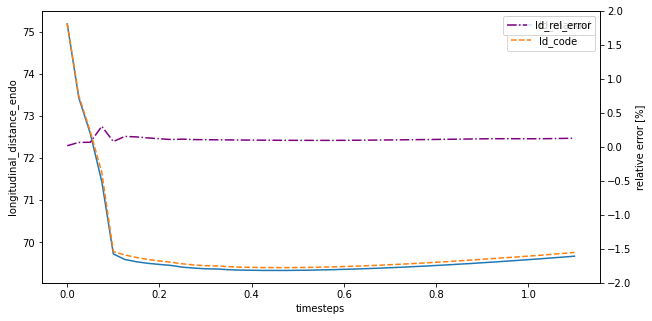

In [22]:
ax = df_comp.plot(x="timesteps", y=["ld_manual", "ld_code"], style=["-", "--"], figsize=(10,5))
ax2 = ax.twinx()
df_comp.plot(
    x="timesteps", 
    y=["ld_rel_error"], 
    style=["-."],
    color=["purple"],
    ax=ax2, )

ax2.set_ylim([-2, 2])
ax.set_ylabel("longitudinal_distance_endo")
ax2.set_ylabel("relative error [%]")
plt.show()

## Radial distance

Compute radial distance

In [23]:
def dist_from_line(p1:np.ndarray, p2:np.ndarray, p3:np.ndarray, dtype:np.dtype=np.float64) -> np.ndarray:
    """Computes the perpendicular distance between one or multiple points [p1] to a line (or lines) \
        defined by [p2, p3]. p2 and p3 must have same shape. points are defined as: [x,y,z].

    Args:
        p1 (np.ndarray): Reference point(s)
        p2 (np.ndarray): First point on line(s)
        p3 (np.ndarray): Second point on line(s)
        dtype (np.dtype, optional): Values are converted to numpy array. This denies the output type. Defaults to np.float64.

    Returns:
        float or np.ndarray: Perpendicular distance(s). If singular point and line, will return float. Otherwise will return an array.
    """
    assert len(p2) == len(p3), "p2 and p3 must have same number of points as they represent lines. Received: p2 ({}), p3 ({})".format(len(p2), len(p3))
    if not isinstance(p1, np.ndarray):
        p1 = np.asarray(p1, dtype=dtype)
        assert p1.shape[-1] == 3, "Point must be composed of [x,y,z]. Received shape (p1): {}".format(p1.shape)
    if not isinstance(p2, np.ndarray):
        p2 = np.asarray(p2, dtype=dtype)
        assert p2.shape[-1] == 3, "Point must be composed of [x,y,z]. Received shape (p2): {}".format(p2.shape)
    if not isinstance(p3, np.ndarray):
        p3 = np.asarray(p3, dtype=dtype)
        assert p3.shape[-1] == 3, "Point must be composed of [x,y,z]. Received shape (p3): {}".format(p3.shape)

    dists = np.linalg.norm(np.cross(p3-p2, p2-p1, axis=-1), axis=-1)/np.linalg.norm(p3-p2, axis=-1)
    # dists = np.linalg.norm(np.cross(p2-p1, p1-p3, axis=-1), axis=-1)/np.linalg.norm(p2-p1, axis=-1)
    return dists.astype(dtype)

In [24]:
rd_endo = []
rd_epi = []
for i in range(45):
    # rs_endo = np.linalg.norm(sb_endo[i, :] - sb_endo_la_center[i], axis=1)
    rd_endo.append(dist_from_line(sb_endo[i], base_center[i], apex_center[i]))
    rd_epi.append(dist_from_line(sb_epi[i], base_center[i], apex_center[i]))
    
rd_endo = np.mean(rd_endo, axis=1)
rd_epi = np.mean(rd_epi, axis=1)

df_comp["rd_endo_manual"] = rd_endo
df_comp["rd_endo_code"] = from_code["radial_distance_endo_superbase"]
df_comp["rd_endo_error"] = rel_error(from_code["radial_distance_endo_superbase"], rd_endo)

df_comp["rd_epi_manual"] = rd_epi
df_comp["rd_epi_code"] = from_code["radial_distance_epi_superbase"]
df_comp["rd_epi_error"] = rel_error(from_code["radial_distance_epi_superbase"], rd_epi)

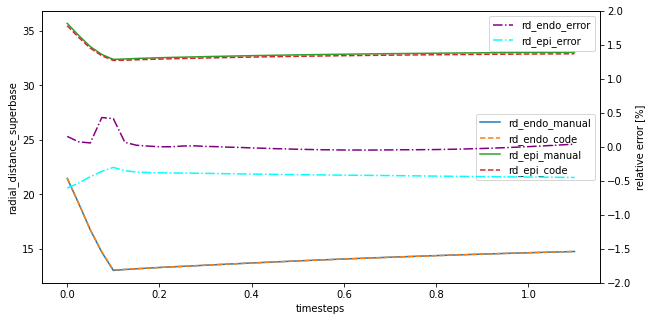

In [25]:
ax = df_comp.plot(
    x="timesteps", 
    y=["rd_endo_manual", "rd_endo_code", "rd_epi_manual", "rd_epi_code"], 
    style=["-", "--", "-", "--"],
    figsize=(10,5))

ax2 = ax.twinx()
df_comp.plot(
    x="timesteps", 
    y=["rd_endo_error", "rd_epi_error"], 
    style=["-.", "-."],
    color=["purple", "cyan"],
    ax=ax2, )

ax2.set_ylim([-2, 2])
ax.set_ylabel("radial_distance_superbase")
ax2.set_ylabel("relative error [%]")
plt.show()

## Wall thickness

Compute wall thickness

In [26]:
wt = rd_epi - rd_endo
df_comp["wt_manual"] = wt
df_comp["wt_code"] = from_code["wall_thickness_superbase"]
df_comp["wt_rel_error"] = rel_error(from_code["wall_thickness_superbase"], wt)

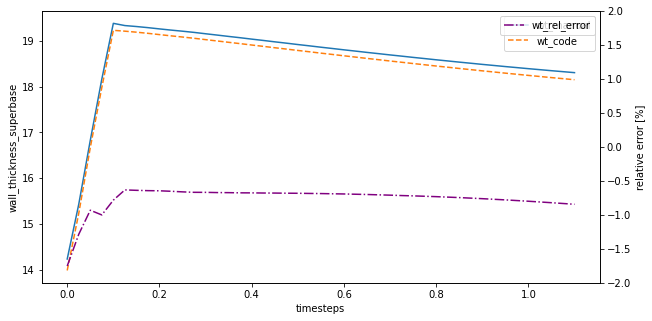

In [27]:
ax = df_comp.plot(
    x="timesteps", 
    y=["wt_manual", "wt_code"], 
    style=["-", "--"],
    figsize=(10,5))
ax2 = ax.twinx()
df_comp.plot(
    x="timesteps", 
    y=["wt_rel_error"], 
    style=["-."],
    color=["purple"],
    ax=ax2, )

ax2.set_ylim([-2, 2])
ax.set_ylabel("wall_thickness_superbase")
ax2.set_ylabel("relative error [%]")
plt.show()

## Circumferential length

Compute circumferential length

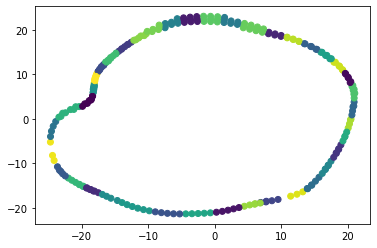

In [28]:
from sklearn.cluster import KMeans

n_clusters = 40
clustering = KMeans(n_clusters=n_clusters, random_state=0).fit(sb_endo[0, :, :2])
labels = clustering.labels_

centers = []
for k in range(n_clusters):
    mask = np.where(labels==k)[0]
    centers.append([np.mean(x[mask], axis=1) for x in sb_endo])

from matplotlib import pyplot as plt
plt.scatter(sb_endo[0, :, 0], sb_endo[0, :, 1], c=labels)
# plt.scatter(sb_endo[0, :, 0], sb_endo[0, :, 1], c=labels)

In [29]:
def sort_by_spherical(xyz):
    # transform to spherical coordinates
    rs = np.linalg.norm(xyz, axis=1)
    thetas = np.arccos(xyz[:, 2]/rs)
    phis = np.arctan2(xyz[:, 1],xyz[:, 0])
    # sort by columns
    ids = np.lexsort((rs, thetas, phis))
    return xyz[ids]

In [30]:
centers = []
for x in sb_endo:
    c = np.asarray([np.mean(x[np.where(labels==k)[0]], axis=0) for k in range(n_clusters)])
    centers.append(sort_by_spherical(c))
centers = np.asarray(centers)

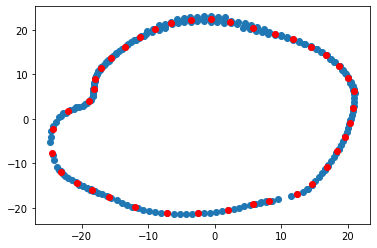

In [31]:
plt.scatter(sb_endo[0, :, 0], sb_endo[0, :, 1])
plt.scatter(centers[0, :, 0], centers[0, :, 1], c="red")

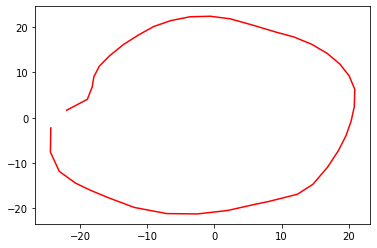

In [32]:
plt.plot(centers[0, :, 0], centers[0, :, 1], c="red")

In [33]:
def line_sum(coords, join_ends=False):
    if not join_ends:
        return np.sum(np.linalg.norm(coords[1:]-coords[:-1], axis=1))
    else:
        _coords = np.vstack((coords, coords[0]))
        return np.sum(np.linalg.norm(_coords[1:]-_coords[:-1], axis=1))


In [34]:
sc = np.asarray([line_sum(x, join_ends=True) for x in centers])
df_comp["sc_manual"] = sc
df_comp["sc_code"] = from_code["global_circumferential_length_endo_superbase"]
df_comp["sc_rel_error"] = rel_error(from_code["global_circumferential_length_endo_superbase"], sc)

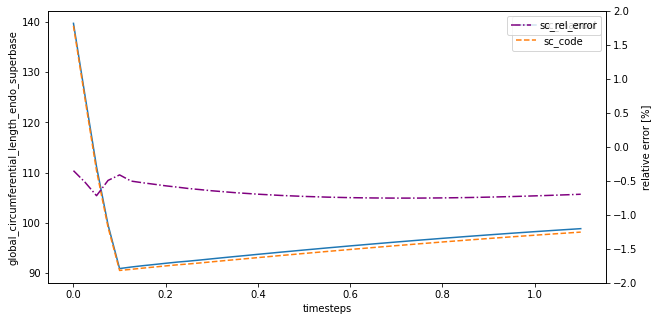

In [35]:
ax = df_comp.plot(
    x="timesteps", 
    y=["sc_manual", "sc_code"], 
    style=["-", "--"],
    figsize=(10,5))
ax2 = ax.twinx()
df_comp.plot(
    x="timesteps", 
    y=["sc_rel_error"], 
    style=["-."],
    color=["purple"],
    ax=ax2, )

ax2.set_ylim([-2, 2])
ax.set_ylabel("global_circumferential_length_endo_superbase")
ax2.set_ylabel("relative error [%]")
plt.show()

## Longitudinal length

Compute Longitudinal length

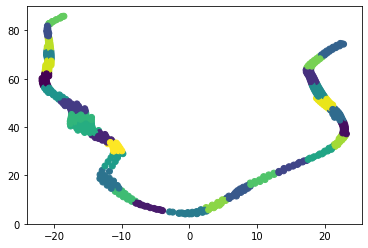

In [36]:
from sklearn.cluster import KMeans

n_clusters = 30
clustering = KMeans(n_clusters=n_clusters, random_state=0).fit(l1[0, :])
labels = clustering.labels_

centers = []
for k in range(n_clusters):
    mask = np.where(labels==k)[0]
    centers.append([np.mean(x[mask], axis=1) for x in l1])

from matplotlib import pyplot as plt
plt.scatter(l1[0, :, 1], l1[0, :, 2], c=labels)
# plt.scatter(sb_endo[0, :, 0], sb_endo[0, :, 1], c=labels)

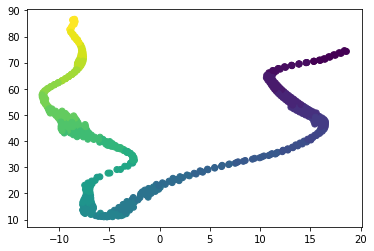

In [37]:
from project_heart.utils.vector_utils import angle_between, project_pts_onto_plane, calc_plane_d

normal = [1,0,0] # plane normal
ref_vector = [0,0,1] # vec to compute angles (so we can sort)
ref_center = np.mean(l1[0, :], axis=0) # center of pts

# project points into plane
plane_d = calc_plane_d(normal, ref_center)
ppts = project_pts_onto_plane(l1[0, :], normal, plane_d)
p_center = project_pts_onto_plane(ref_center, normal, plane_d)[0]

# get vectors from center to projected points
vecs = clustering.cluster_centers_ - p_center 

# compute angles
angles = angle_between(vecs, ref_vector, check_orientation=True, zaxis=normal) 
# sort angles
idx = np.argsort(angles)
# reconstruct labels
labels_order = np.zeros_like(idx)
labels_order[idx] = np.arange(n_clusters)
new_labels = np.asarray([labels_order[v] for v in labels])
labels = new_labels

# plot 
plt.scatter(l1[6, :, 1], l1[6, :, 2], c=labels)

In [38]:
centers = []
for x in l1:
    c = np.asarray([np.mean(x[np.where(labels==k)[0]], axis=0) for k in range(n_clusters)])
    # centers.append(sort_by_zs_ys(c))
    centers.append(c)
centers = np.asarray(centers)

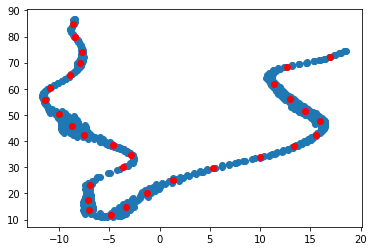

In [39]:
plt.scatter(l1[6, :, 1], l1[6, :, 2])
plt.scatter(centers[6, :, 1], centers[6, :, 2], c="red")

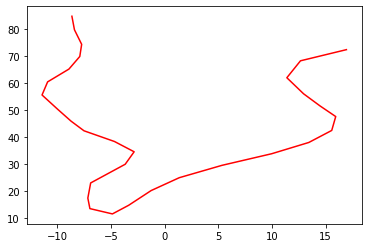

In [40]:
plt.plot(centers[6, :, 1], centers[6, :, 2], c="red")

In [41]:
sl = np.asarray([line_sum(x) for x in centers])

df_comp["sl_manual"] = sl
df_comp["sl_code"] = from_code["global_longitudinal_length_endo_0.0"]
df_comp["sl_rel_error"] = rel_error(from_code["global_longitudinal_length_endo_0.0"], sl)

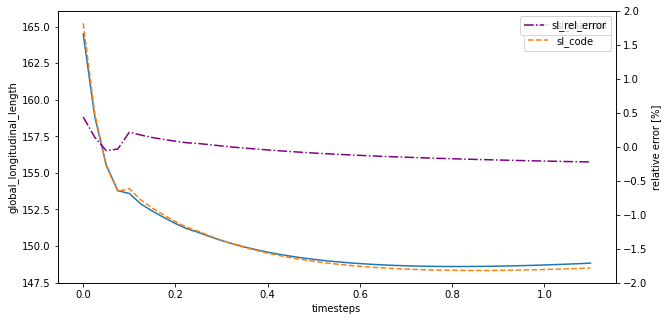

In [42]:
ax = df_comp.plot(
    x="timesteps", 
    y=["sl_manual", "sl_code"], 
    style=["-", "--"],
    figsize=(10,5))
ax2 = ax.twinx()
df_comp.plot(
    x="timesteps", 
    y=["sl_rel_error"], 
    style=["-."],
    color=["purple"],
    ax=ax2)

ax2.set_ylim([-2, 2])
ax.set_ylabel("global_longitudinal_length")
ax2.set_ylabel("relative error [%]")
plt.show()

Check if we are comparing same nodes (from manual and speckles)

In [43]:
spks_code = lv.nodes(mask=spks4.stack_ids())
spks_manual = l1[0, :]

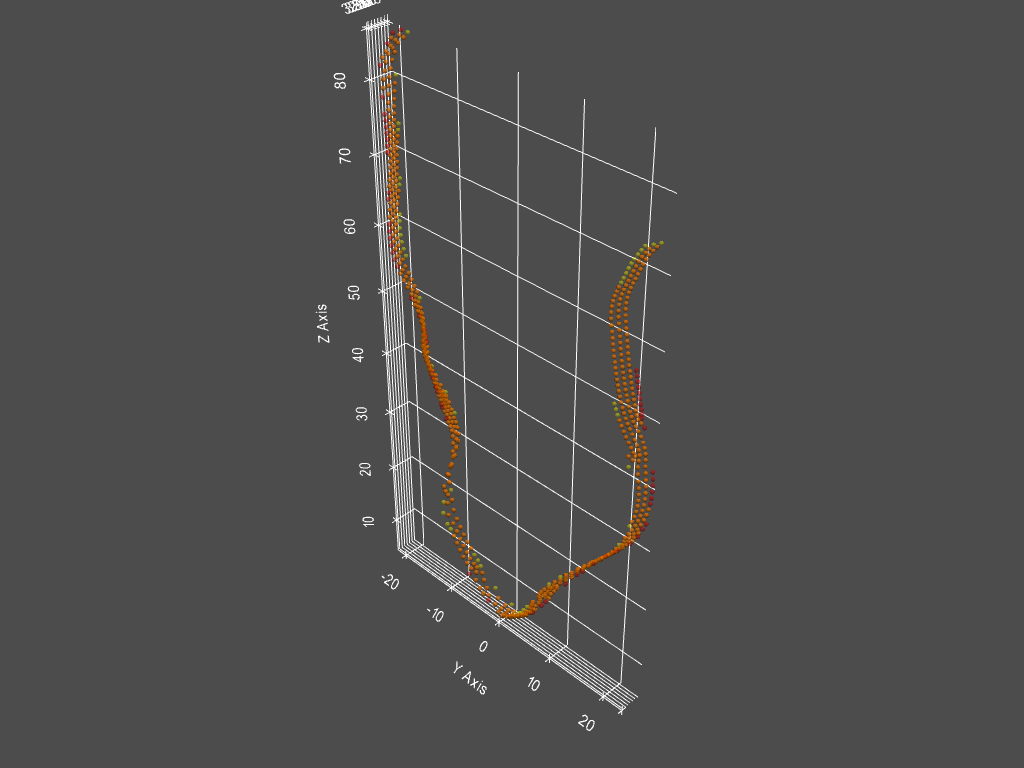

In [44]:
plotter = pv.Plotter()
plotter.add_mesh(pv.PolyData(spks_code), render_points_as_spheres=True, color="red", opacity=0.5)
plotter.add_mesh(pv.PolyData(spks_manual), render_points_as_spheres=True, color="yellow", opacity=0.5)
plotter.show_grid()
plotter.show(jupyter_backend='static')